In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

In [2]:
all_metrics_table = []

In [3]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [5]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [6]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

In [7]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7867401104915408+-0.00852135511666111


In [8]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386937, F-Score=0.730, Precision=0.647, Recall=0.838


In [9]:
test_auc = roc_auc_score(y_test, y_score)

In [10]:
all_metrics_table.append([thresholds[ix], fscore[ix], precision[ix], recall[ix],test_auc])

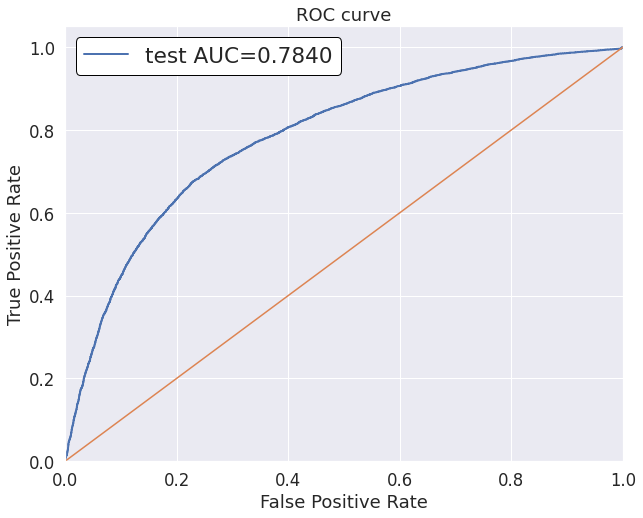

In [11]:
import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='test AUC={:.4f}'.format(test_auc))
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

Попробуем RandomForest

In [12]:
from sklearn.ensemble import RandomForestClassifier
classifier = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [13]:
params = {'classifier__n_estimators':[100,200,300],
          'classifier__max_depth': [5, 10, 15]
          }

In [14]:
CV_model = GridSearchCV(estimator=classifier, 
                            param_grid=params,
                            cv=10, 
                            scoring='roc_auc',
                            n_jobs=-1, 
                            verbose=False)
CV_model.fit(X_train, y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('age',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         NumberSelector(key='age')),
                                                                                        ('standard',
                                                                                         StandardScaler(copy=True,
                                                                                                        with_mean=True,
                                                                         

In [17]:
print(f'Лучшие параметры: {CV_model.best_params_}')
print('CV best score is {}'.format(CV_model.best_score_))
y_score = CV_model.predict_proba(X_test)[:, 1]

Лучшие параметры: {'classifier__max_depth': 10, 'classifier__n_estimators': 300}
CV best score is 0.8018473395216252


In [19]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.377605, F-Score=0.740, Precision=0.675, Recall=0.818


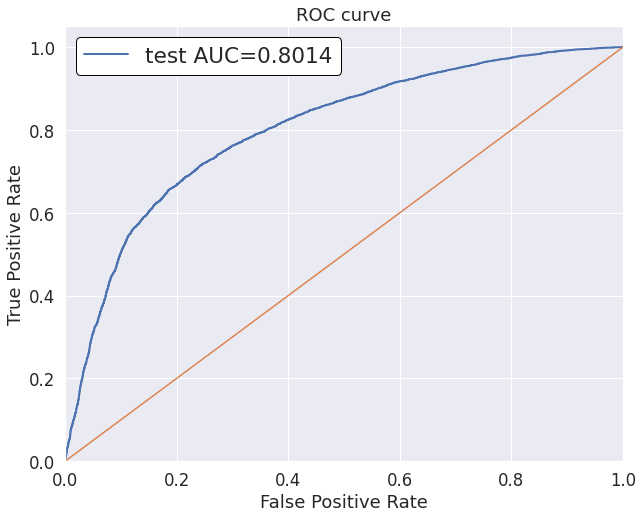

In [20]:
test_auc = roc_auc_score(y_test, y_score)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='test AUC={:.4f}'.format(test_auc))
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

In [21]:
all_metrics_table.append([thresholds[ix], fscore[ix], precision[ix], recall[ix],test_auc])

Попробуем Catboost

In [100]:
from catboost import CatBoostClassifier

In [101]:
X_train, X_val, y_train, y_val = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

In [102]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol','gluc', 'smoke', 'alco', 'active']

In [103]:
frozen_params = {
     'silent':True,
     'random_state':42,
     'cat_features':cat_cols,
     'eval_metric':'AUC',
     'early_stopping_rounds':50,
     'task_type': 'GPU'
}

In [104]:
clf = CatBoostClassifier(**frozen_params)

In [105]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [106]:
params = {'n_estimators':[1000, 2000,3000], 
          'max_depth':[7, 9],
          'l2_leaf_reg': [9, 15]
          }

In [ ]:
grid_search = clf.grid_search(params, X_train, y_train, cv=cv, stratified=True, refit=True)

In [108]:
print("\nBest Params : ", grid_search['params'])


Best Params :  {'depth': 9, 'l2_leaf_reg': 15, 'iterations': 3000}


In [110]:
y_score = clf.predict_proba(X_val)[:, 1]

In [111]:
b=1
precision, recall, thresholds = precision_recall_curve(y_val.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.350001, F-Score=0.739, Precision=0.663, Recall=0.836


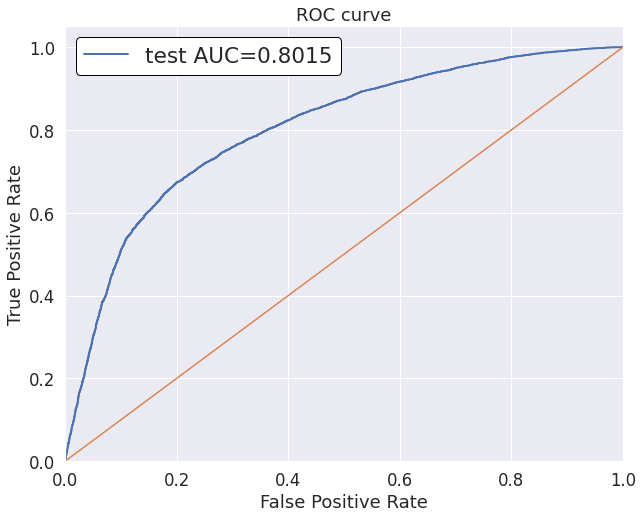

In [112]:
test_auc = roc_auc_score(y_val, y_score)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='test AUC={:.4f}'.format(test_auc))
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

In [114]:
clf_catboost = CatBoostClassifier(**frozen_params, **grid_search['params'])

In [115]:
clf_catboost.fit(X_train, y_train, eval_set=(X_val, y_val))

In [116]:
y_score = clf_catboost.predict_proba(X_val)[:, 1]

In [117]:
b=1
precision, recall, thresholds = precision_recall_curve(y_val.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.363757, F-Score=0.740, Precision=0.676, Recall=0.818


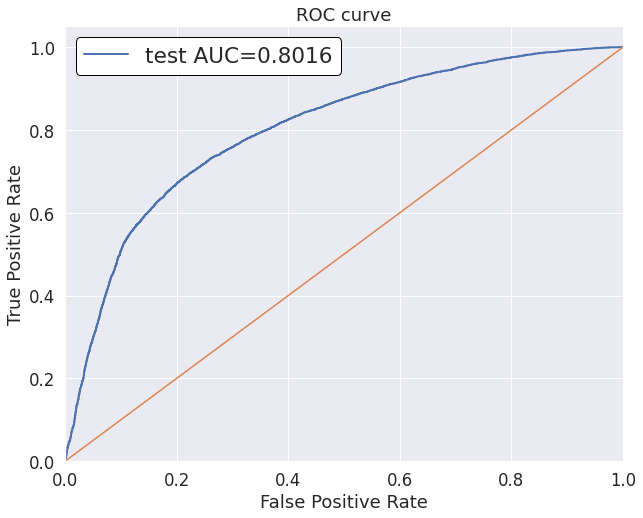

In [118]:
test_auc = roc_auc_score(y_val, y_score)

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='test AUC={:.4f}'.format(test_auc))
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

In [120]:
all_metrics_table.append([thresholds[ix], fscore[ix], precision[ix], recall[ix],test_auc])

In [123]:
result = pd.DataFrame(all_metrics_table, columns=['threshold', 'F-Score', 'Precision', 'Recall', 'ROC_AUC'], index=['LogReg','RandomForest','Catboost'])
result

,threshold,F-Score,Precision,Recall,ROC_AUC
LogReg,0.386937,0.730323,0.647431,0.837558,0.784035
RandomForest,0.377605,0.739653,0.674708,0.818433,0.801391
Catboost,0.363757,0.739965,0.675776,0.817627,0.801595


RandomForest и Catboost - идут ноздря в ноздрю, что и ожидаемо. Но LogReg, впринципе показал себя тоже не плохо.
